## Importing Necessary Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [2]:
!pip install transformers
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

## Import Dataset and PreProcessing

In [3]:
url = 'https://github.com/errhythm/BDFoodAppSentiment/raw/main/Dataset.csv'
df = pd.read_csv(url)
print(df.shape)

(15017, 5)


In [4]:
df = df.sample(frac=1).reset_index(drop=True)
df = df.drop(['Unnamed: 0'], axis=1)
df['id'] = df.index
df.head()

,createdAt,text,reviewerName,ratingvalue,id
0,2022-02-04T11:10:14.474Z,he received my order around 2.30 pm but delive...,Anonymous,4,0
1,2022-07-16T05:59:24Z,taste was not that good. and the amount of cof...,Israel,1,1
2,2022-04-24T12:15:02.221Z,It is better if the girl is a little bigger,Anonymous,5,2
3,2021-11-16T15:55:42.189Z,take too much time. today i feel very angry,Zerin Ibnat,1,3
4,2022-06-30T05:53:21Z,Coleslaw was not fresh and it had a bad smell....,faria,1,4


In [5]:
ax = df["ratingvalue"].value_counts().sort_index()

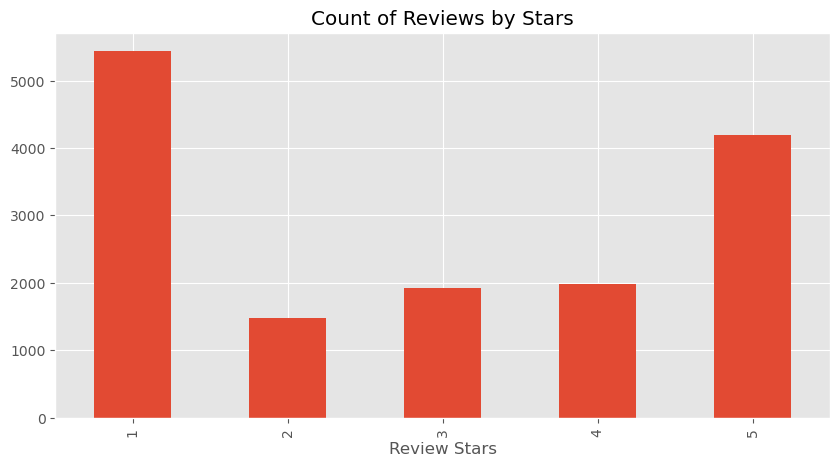

In [6]:
ax = df["ratingvalue"].value_counts().sort_index().plot(kind="bar", title="Count of Reviews by Stars", figsize=(10,5))

ax.set_xlabel('Review Stars')
plt.savefig('stars.pdf')
plt.show()

# Models

## Roberta

In [17]:
MODEL = f'cardiffnlp/twitter-roberta-base-sentiment'
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [18]:
def polarity_scores_roberta(example):
  encoded_text = tokenizer(example, return_tensors = 'pt')
  output = model(**encoded_text)
  scores = output[0][0].detach().numpy()
  scores = softmax(scores)
  scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
  }
  return scores_dict

In [19]:
res = {}
vader_result_rename = {}
for i,row in tqdm(df.iterrows(), total = len(df)):
  text = row['text']
  myid = i
  vader_result = sia.polarity_scores(text)
  for key,value in vader_result.items():
    vader_result_rename[f'vader_{key}'] = value
  roberta_result = polarity_scores_roberta(text)
  both = {**vader_result_rename, **roberta_result}
  res[myid] = both

  0%|          | 0/15017 [00:00<?, ?it/s]

In [20]:
results_df = pd.DataFrame(res).T
results_df= results_df.reset_index().rename(columns={"index":"id"})
results_df = results_df.merge(df, how="left")

In [21]:
results_df

,id,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos,createdAt,text,reviewerName,ratingvalue
0,0,0.000,1.000,0.000,0.0000,0.008115,0.804791,0.187094,2022-02-04T11:10:14.474Z,he received my order around 2.30 pm but delive...,Anonymous,4
1,1,0.167,0.833,0.000,-0.3412,0.915435,0.075450,0.009115,2022-07-16T05:59:24Z,taste was not that good. and the amount of cof...,Israel,1
2,2,0.000,0.734,0.266,0.4404,0.041308,0.409943,0.548750,2022-04-24T12:15:02.221Z,It is better if the girl is a little bigger,Anonymous,5
3,3,0.339,0.661,0.000,-0.5563,0.953995,0.041070,0.004935,2021-11-16T15:55:42.189Z,take too much time. today i feel very angry,Zerin Ibnat,1
4,4,0.374,0.626,0.000,-0.8386,0.963817,0.032379,0.003804,2022-06-30T05:53:21Z,Coleslaw was not fresh and it had a bad smell....,faria,1
...,...,...,...,...,...,...,...,...,...,...,...,...
15012,15012,0.000,0.263,0.737,0.4215,0.039455,0.282166,0.678379,2021-06-27T10:38:17.471Z,nice taste,Anonymous,5
15013,15013,0.000,0.408,0.592,0.4404,0.002754,0.041969,0.955276,2021-10-26T07:56:19.798Z,Taste is good.,Anonymous,5
15014,15014,0.000,0.738,0.262,0.4927,0.001298,0.014188,0.984514,2022-08-18T13:13:11Z,Masha Allah the food was very good today too. ...,Mithila,5
15015,15015,0.000,1.000,0.000,0.0000,0.859449,0.132488,0.008062,2021-10-30T09:29:16.450Z,Chicken was undercooked,Towsif Al Hafiz,4


In [22]:
tp = 0
for i,row in results_df.iterrows():
  positive = row["roberta_pos"]
  negative = row["roberta_neg"]
  neutral = row["roberta_neu"]
  if(max(positive,negative,neutral) == positive and row["ratingvalue"]==4 or row["ratingvalue"]==5):
    tp+=1
  elif(max(positive,negative,neutral) == neutral and row["ratingvalue"]==3):
    tp+=1
  elif(max(positive,negative,neutral) == negative and row["ratingvalue"]==1 or row["ratingvalue"]==2):
    tp+=1

roberta_accuracy = (tp)/(results_df.shape[0])



In [23]:
tp = 0
fp = 0 
for i,row in results_df.iterrows():
  positive = row["roberta_pos"]
  negative = row["roberta_neg"]
  neutral = row["roberta_neu"]
  if(max(positive,negative,neutral) == positive and row["ratingvalue"]==4 or row["ratingvalue"]==5):
    tp+=1
  elif(max(positive,negative,neutral) == neutral and row["ratingvalue"]==3):
    tp+=1
  elif(max(positive,negative,neutral) == negative and row["ratingvalue"]==1 or row["ratingvalue"]==2):
    tp+=1
  elif(max(positive,negative,neutral) == positive and row["ratingvalue"]<4):
    fp+=1
roberta_precision = (tp)/(tp+fp)




In [24]:
tp = 0
fn = 0 
for i,row in results_df.iterrows():
  positive = row["roberta_pos"]
  negative = row["roberta_neg"]
  neutral = row["roberta_neu"]
  if(max(positive,negative,neutral) == positive and row["ratingvalue"]==4 or row["ratingvalue"]==5):
    tp+=1
  elif(max(positive,negative,neutral) == neutral and row["ratingvalue"]==3):
    tp+=1
  elif(max(positive,negative,neutral) == negative and row["ratingvalue"]==1 or row["ratingvalue"]==2):
    tp+=1
  if(max(positive,negative,neutral) == negative and row["ratingvalue"]>2):
    fn+=1
  if(max(positive,negative,neutral) == negative and row["ratingvalue"]!=3):  
    fn+=1
    
roberta_recall = (tp)/(tp+fn)

In [25]:
roberta_f1_Score = 2 * (roberta_precision * roberta_recall) / (roberta_precision + roberta_recall)

In [26]:
print("Roberta accuracy: " + str(roberta_accuracy))
print("Roberta Precision: " + str(roberta_precision))
print("Roberta Recall: " + str(roberta_recall))
print("Roberta F1 Score: " + str(roberta_f1_Score))

Roberta accuracy: 0.7366984084704002
Roberta Precision: 0.9716318285613912
Roberta Recall: 0.5505897576270343
Roberta F1 Score: 0.7028812859366563


## DistilBERT

In [27]:
from transformers import pipeline

sent_pipeline = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [28]:
res = {}
pipeline_result_rename = {}
for i,row in tqdm(df.iterrows(), total = len(df)):
    text = row['text']
    myid = i
    pipeline_result = sent_pipeline(text)
    for key,value in pipeline_result[0].items():
        pipeline_result_rename[f'pipeline_{key}'] = value
    res[myid] = pipeline_result_rename.copy()

  0%|          | 0/15017 [00:00<?, ?it/s]

In [29]:
results_df2 = pd.DataFrame(res).T
results_df2= results_df2.reset_index().rename(columns={"index":"id"})
results_df2 = results_df2.merge(df, how="left")

In [30]:
pos_reviews = results_df2[results_df2.pipeline_label == 'POSITIVE']
pos_text = " ".join(review for review in pos_reviews.text)
neg_reviews = results_df2[results_df2.pipeline_label == 'NEGATIVE']
neg_text = " ".join(review for review in neg_reviews.text)

In [31]:
neg_reviews = neg_reviews[neg_reviews.ratingvalue <4]
pos_reviews = pos_reviews[pos_reviews.ratingvalue >3]
distilbert_accuracy = (neg_reviews.shape[0] + pos_reviews.shape[0]) / results_df2.shape[0]

In [32]:
neg_reviews = results_df2[results_df2.pipeline_label == 'NEGATIVE']
pos_reviews = results_df2[results_df2.pipeline_label == 'POSITIVE']

In [33]:
precision_pos_reviews = pos_reviews[pos_reviews.ratingvalue <4]

distilbert_precision = pos_reviews.shape[0]/(precision_pos_reviews.shape[0]+pos_reviews.shape[0])


In [34]:
recall_neg_reviews = neg_reviews[neg_reviews.ratingvalue >3]
distilbert_recall = (neg_reviews.shape[0] + pos_reviews.shape[0])/(recall_neg_reviews.shape[0]+(neg_reviews.shape[0] + pos_reviews.shape[0]))


In [35]:
distilbert_f1_Score = 2 * (distilbert_precision * distilbert_recall) / (distilbert_precision + distilbert_recall)

In [36]:
print("DistilBERT accuracy: " + str(distilbert_accuracy))
print("DistilBERT Precision: " + str(distilbert_precision))
print("DistilBERT Recall: " + str(distilbert_recall))
print("DistilBERT F1 Score: " + str(distilbert_f1_Score))

DistilBERT accuracy: 0.7673969501231938
DistilBERT Precision: 0.8289807762060211
DistilBERT Recall: 0.8548414641088404
DistilBERT F1 Score: 0.8417125317426934


## BERT

In [37]:
sent_pipeline = pipeline("sentiment-analysis", model="nlptown/bert-base-multilingual-uncased-sentiment")

In [38]:
res = {}
pipeline_result_rename = {}
for i,row in tqdm(df.iterrows(), total = len(df)):
    text = row['text']
    myid = i
    pipeline_result = sent_pipeline(text)
    for key,value in pipeline_result[0].items():
        pipeline_result_rename[f'pipeline_{key}'] = value
    res[myid] = pipeline_result_rename.copy()

  0%|          | 0/15017 [00:00<?, ?it/s]

In [39]:
results_df3 = pd.DataFrame(res).T
results_df3= results_df3.reset_index().rename(columns={"index":"id"})
results_df3 = results_df3.merge(df, how="left")

In [40]:
results_df3

,id,pipeline_label,pipeline_score,createdAt,text,reviewerName,ratingvalue
0,0,1 star,0.507326,2022-02-04T11:10:14.474Z,he received my order around 2.30 pm but delive...,Anonymous,4
1,1,2 stars,0.561847,2022-07-16T05:59:24Z,taste was not that good. and the amount of cof...,Israel,1
2,2,3 stars,0.577202,2022-04-24T12:15:02.221Z,It is better if the girl is a little bigger,Anonymous,5
3,3,2 stars,0.447705,2021-11-16T15:55:42.189Z,take too much time. today i feel very angry,Zerin Ibnat,1
4,4,1 star,0.451526,2022-06-30T05:53:21Z,Coleslaw was not fresh and it had a bad smell....,faria,1
...,...,...,...,...,...,...,...
15012,15012,4 stars,0.473838,2021-06-27T10:38:17.471Z,nice taste,Anonymous,5
15013,15013,4 stars,0.509026,2021-10-26T07:56:19.798Z,Taste is good.,Anonymous,5
15014,15014,5 stars,0.620138,2022-08-18T13:13:11Z,Masha Allah the food was very good today too. ...,Mithila,5
15015,15015,1 star,0.410384,2021-10-30T09:29:16.450Z,Chicken was undercooked,Towsif Al Hafiz,4


In [41]:
pos_reviews = results_df3[(results_df3.pipeline_label == "4 stars") | (results_df3.pipeline_label == "5 stars")]
neg_reviews = results_df3[(results_df3.pipeline_label == "3 stars") | (results_df3.pipeline_label == "2 stars") | (results_df3.pipeline_label == "1 star")]
pos_reviews.shape
neg_reviews.shape

pos_reviews = pos_reviews[pos_reviews.ratingvalue>3]
neg_reviews = neg_reviews[neg_reviews.ratingvalue<4]
bert_accuracy = (neg_reviews.shape[0] + pos_reviews.shape[0]) / results_df3.shape[0]

In [42]:
pos_reviews = results_df3[(results_df3.pipeline_label == "4 stars") | (results_df3.pipeline_label == "5 stars")]
neg_reviews = results_df3[(results_df3.pipeline_label == "3 stars") | (results_df3.pipeline_label == "2 stars") | (results_df3.pipeline_label == "1 star")]

In [43]:
precision_pos_reviews = pos_reviews[pos_reviews.ratingvalue <4]
precision_pos_reviews.shape
bert_precision = pos_reviews.shape[0]/(precision_pos_reviews.shape[0]+pos_reviews.shape[0])

In [44]:
recall_neg_reviews = neg_reviews[neg_reviews.ratingvalue >3]
bert_recall = (neg_reviews.shape[0] + pos_reviews.shape[0])/(recall_neg_reviews.shape[0]+(neg_reviews.shape[0] + pos_reviews.shape[0]))

In [47]:
bert_f1_score = 2 * (bert_precision * bert_recall) / (bert_precision+bert_recall)

In [51]:
print("BERT accuracy: " + str(bert_accuracy))
print("BERT Precision: " + str(bert_precision))
print("BERT Recall: " + str(bert_recall))
print("BERT F1 Score: " + str(bert_f1_score))

BERT accuracy: 0.7585403209695678
BERT Precision: 0.8483554036736437
BERT Recall: 0.8373947471142587
BERT F1 Score: 0.8428394425950585


## Afinn

In [52]:
!pip install afinn
from afinn import Afinn

# Initialize the Afinn object
afinn = Afinn()

In [53]:
res = {}
pipeline_result_rename = {}
for i,row in tqdm(df.iterrows(), total = len(df)):
    text = row['text']
    myid = i
    value = afinn.score(text)
    pipeline_result_rename["score"] = value
    res[myid] = pipeline_result_rename.copy()

  0%|          | 0/15017 [00:00<?, ?it/s]

In [54]:
results_df4 = pd.DataFrame(res).T
results_df4= results_df4.reset_index().rename(columns={"index":"id"})
results_df4 = results_df4.merge(df, how="left")

In [55]:
pos_reviews = results_df4[(results_df4.score>0)]
neg_reviews = results_df4[(results_df4.score<=0)]

pos_reviews = pos_reviews[pos_reviews.ratingvalue>3]
neg_reviews = neg_reviews[neg_reviews.ratingvalue<4]
afinn_accuracy = (neg_reviews.shape[0] + pos_reviews.shape[0]) / results_df4.shape[0]

In [56]:
pos_reviews = results_df4[(results_df4.score>0)]
neg_reviews = results_df4[(results_df4.score<=0)]

In [57]:
precision_pos_reviews = pos_reviews[pos_reviews.ratingvalue <4]
precision_pos_reviews.shape
afinn_precision = pos_reviews.shape[0]/(precision_pos_reviews.shape[0]+pos_reviews.shape[0])

In [58]:
recall_neg_reviews = neg_reviews[neg_reviews.ratingvalue >3]
afinn_recall = (neg_reviews.shape[0] + pos_reviews.shape[0])/(recall_neg_reviews.shape[0]+(neg_reviews.shape[0] + pos_reviews.shape[0]))

In [59]:
afinn_f1score = 2 * (afinn_precision * afinn_recall) / (afinn_precision + afinn_recall)

In [61]:
print("Afinn accuracy: " + str(afinn_accuracy))
print("Afinn Precision: " + str(afinn_precision))
print("Afinn Recall: " + str(afinn_recall))
print("Afinn F1 Score: " + str(afinn_f1score))

Afinn accuracy: 0.7273756409402677
Afinn Precision: 0.7682409709021787
Afinn Recall: 0.8568412644071665
Afinn F1 Score: 0.8101258515719454
